# 04 - Pix2Pix dev

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from botocore.exceptions import ClientError
import boto3
import calendar
import io
from itertools import product
import numpy as np
import os
import pandas as pd
import random
import tifffile as tif
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from models.pix2pix_model import Pix2PixModel

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/loaner/.pyenv/versions/3.8.15/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = 'data'
BUCKET_NAME = 'drivendata-competition-biomassters-public-us'
RANDOM_STATE = 42

s3_client = boto3.client(
    's3',
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY']
)
s3_resource = boto3.resource(
    's3',
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY']
)
s3_bucket = s3_resource.Bucket(BUCKET_NAME)

month_map = {month: index for index, month in enumerate(calendar.month_name) if month}

In [3]:
def load_tif_from_s3(s3_bucket, key):
    try:
        object = s3_bucket.Object(key)
        img_data = object.get().get('Body').read()
        img = tif.imread(io.BytesIO(img_data))
        return reshape_tif(img)
        
    except ClientError as e:
        if e.response['Error']['Code'] == 'NoSuchKey':
            print("Error: No such key")
            img = None
            
def reshape_tif(img):
    if len(np.shape(img))==3:
        return np.moveaxis(img,2,0)
    elif len(np.shape(img))==2:
        return img
    else:
        raise ValueError(f"Unknown image shape {np.shape(img)}")


def download_from_s3(s3_bucket, key, out_path):
    try:
        s3_bucket.download_file(key, out_path)
    except ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

def load_tif(s3_bucket, key, out_path=None, local=False, reshape=False):
    if local:
        if not os.path.exists(out_path):
            download_from_s3(s3_bucket, key, out_path)
        img = tif.imread(out_path)
            
    else:
        img = load_tif_from_s3(s3_bucket, key)
    if reshape:
        return reshape_tif(img)
    else:
        return img
    

In [36]:
class BiomassDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, data, metadata, s3_bucket, local=True):
        self.data = data
        self.metadata = metadata
        self.s3_bucket = s3_bucket
        self.local = local
        
        self.dummy_s1_missing_value = 256
        self.dummy_s2_missing_value = -9999        
        self.dummy_s1_missing_img = np.ones([256,256,4])*self.dummy_s1_missing_value
        self.dummy_s2_missing_img = np.ones([256,256,11])*self.dummy_s2_missing_value
        
        self.transform_X = transforms.Compose(
            [
                # transforms.Resize((224, 224)),
                transforms.ToTensor(),
                # transforms.Normalize(
                #     mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                # ),
            ]
        )
        self.transform_y = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
    
    def __getitem__(self, index):
        chip_id = self.data['chip_id'].iloc[index]
        X = self._load_chip_feature_data(chip_id)
        y = self._load_chip_target_data(chip_id)
        self.X = self.transform_X(X).float()
        self.y = self.transform_y(y).float()
        return  {"chip_id": chip_id, "A": self.X, "B": self.y, "A_paths": '', "B_paths": ''}

    def __len__(self):
        return len(self.data)
    
    def _get_chip_metadata(self, chip_id):
        return self.metadata[self.metadata.chip_id==chip_id]
    
    def _load_chip_feature_data(self, chip_id):
        img_channels = []
        for idx, row in self._get_chip_metadata(chip_id).iterrows():
            if type(row.filename) != str:
                if row.satellite=='S1':
                    img = self.dummy_s1_missing_img
                elif row.satellite=='S2':
                    img = self.dummy_s2_missing_img
                else:
                    raise ValueError("Unknown satellite value")
            else:
                key = f'{row.split}_features/{row.filename}'
                img = load_tif(self.s3_bucket, key, out_path=f'data/{key}', local=self.local)
            img_channels.append(img)
        ret = np.concatenate(img_channels, axis=2)
        return ret
    
    def _load_chip_target_data(self, chip_id):
        filename = self._get_chip_metadata(chip_id).corresponding_agbm.iloc[0]
        key = f'train_agbm/{filename}'
        img = load_tif(self.s3_bucket, key, out_path=f'data/{key}', local=self.local)
        return img

## Data Loader

In [5]:
df_metadata = pd.read_csv("data/metadata/features_metadata.csv",index_col=0)

all_chips = list(df_metadata.chip_id.unique())
train_chips = list(df_metadata[df_metadata.split=='train'].chip_id.unique())
test_chips = list(df_metadata[df_metadata.split=='test'].chip_id.unique())

In [37]:
random.seed(RANDOM_STATE)
train_chips_sample = random.sample(train_chips, 15)

data = pd.DataFrame({'chip_id': train_chips_sample})
metadata = df_metadata[df_metadata.chip_id.isin(train_chips_sample)]
train_bm = BiomassDataset(data, metadata, s3_bucket)
train_dataloader = DataLoader(train_bm, batch_size=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


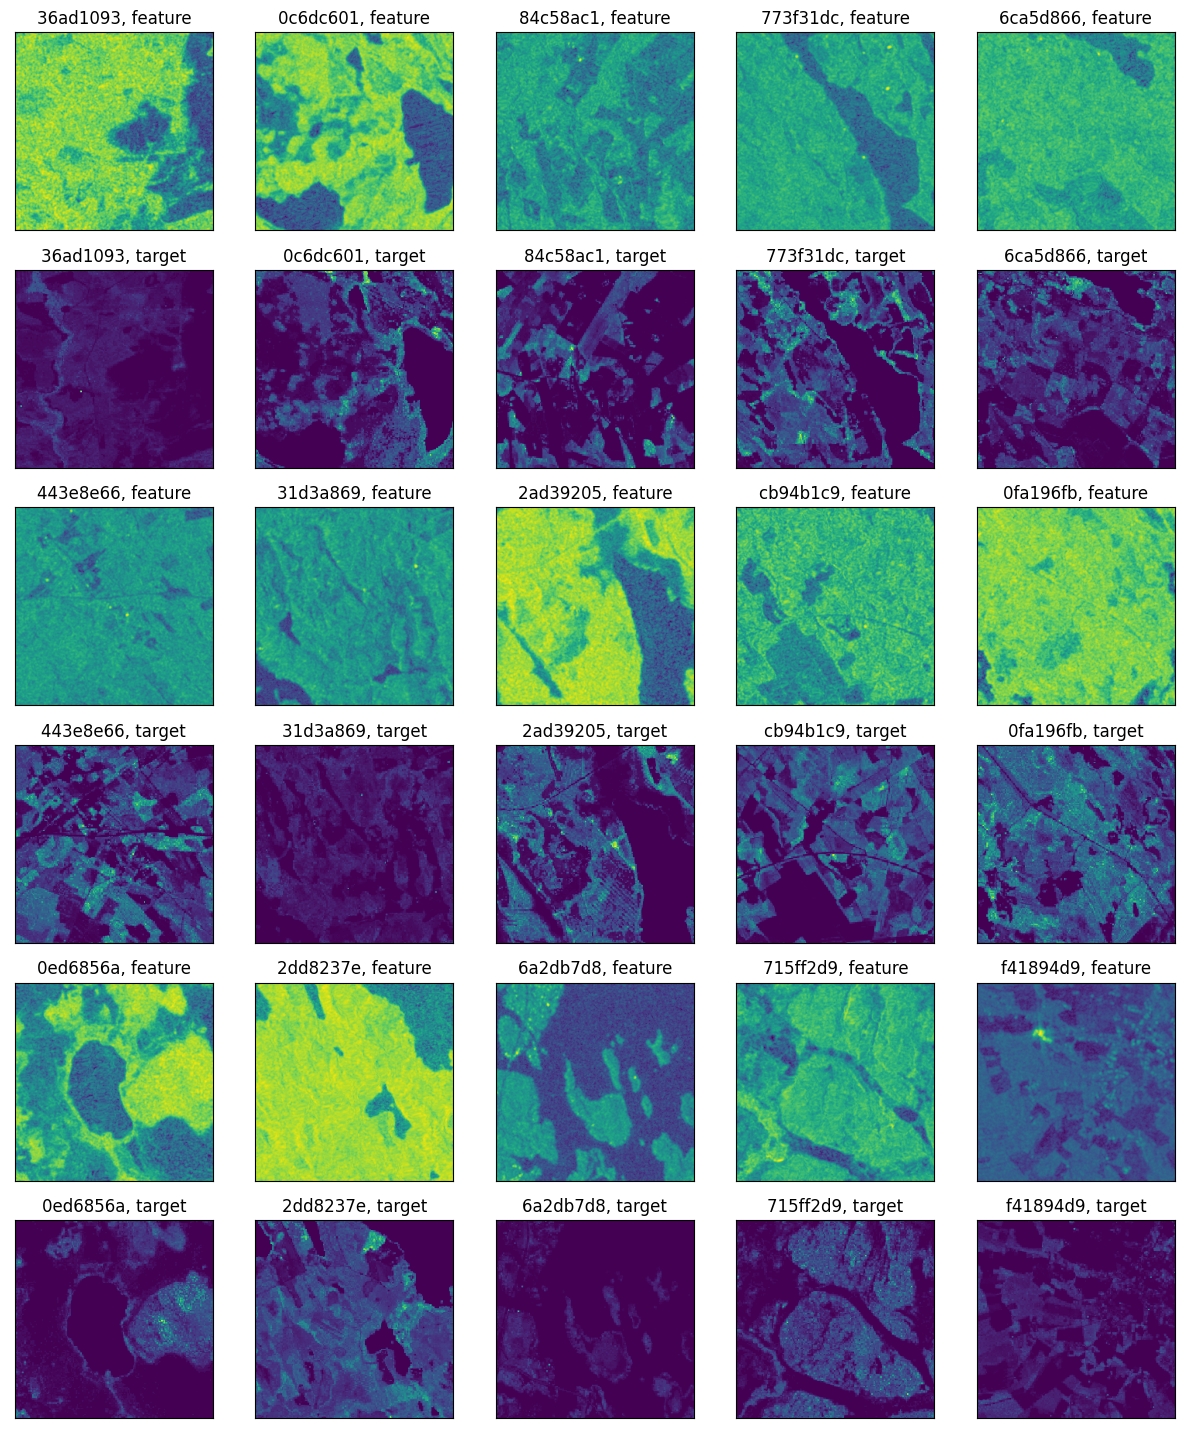

In [73]:
num_steps = len(train_dataloader)
batch_size = 5
channel = 1

fig, axes = plt.subplots(nrows=2*num_steps, ncols=batch_size, figsize=(3*batch_size,6*num_steps))
axes = axes.flatten()

for j, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    for i, (chip_id, a, b) in enumerate(zip(batch['chip_id'], batch['A'], batch['B'])):
        
        data = {
            'feature': a[channel,:,:],
            'target': b[0,:,:],
        }

        for k, (title, img) in enumerate(data.items()):
            idx = i+j*(2*batch_size) + k*batch_size
            axes[idx].imshow(img)
            axes[idx].set_title(f'{chip_id}, {title}')
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])

    

In [69]:
class Options():
    def __init__(self, is_train=False):
        # basic parameters
        self.name = 'biomassters' # name of the experiment. It decides where to store samples and models
        self.gpu_ids = -1,  # gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU
        self.checkpoints_dir = './checkpoints' # models are saved here
        
        # dataset parameters
        self.dataset_mode = 'aligned' # chooses how datasets are loaded. [unaligned | aligned | single | colorization]
        self.direction = 'AtoB' # AtoB or BtoA
        self.preprocess = 'resize_and_crop' # scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]
                
        # train parameters
        self.isTrain = self.is_train # train or test
        self.eval = False if self.is_train else True
        self.lr_policy = 'linear' # learning rate policy. [linear | step | plateau | cosine]
        self.lambda_L1 = 100. # 'weight for L1 loss'
        self.gan_mode = 'gan_mode' # the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.
        self.beta1 = .5 # momentum term of adam
        self.pool_size = 0 # the size of image buffer that stores previously generated images [TRAIN]
        
        # model parameters
        # Common
        self.input_nc = 180 # # of input image channels: 3 for RGB and 1 for grayscale
        self.output_nc = 1 # # of output image channels: 3 for RGB and 1 for grayscale 
        self.norm = 'batch' # instance normalization or batch normalization [instance | batch | none]
        self.init_type = 'normal' # network initialization [normal | xavier | kaiming | orthogonal]
        self.init_gain = 0.02 # scaling factor for normal, xavier and orthogonal.

        # Generator
        self.ngf = 64 # # of gen filters in the last conv layer
        self.netG = 'unet_256' # specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]
        self.no_dropout = 'store_true' # no dropout for the generator
        
        # Discriminator
        self.ndf = 64 # # of discrim filters in the first conv layer
        self.netD = 'basic' # specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator
        self.n_layers_D = 3 # only used if netD==n_layers
        
        # Additional
        self.load_iter = 0 # which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]
        self.epoch = 'latest' # which epoch to load? set to latest to use latest cached model

        

In [88]:
import argparse
# from util import util
# import torch
# import models
# import data


class BaseOptions():
    """This class defines options used during both training and test time.

    It also implements several helper functions such as parsing, printing, and saving the options.
    It also gathers additional options defined in <modify_commandline_options> functions in both dataset class and model class.
    """

    def __init__(self):
        """Reset the class; indicates the class hasn't been initailized"""
        self.initialized = False

    def initialize(self, parser):
        """Define the common options that are used in both training and test."""
        # basic parameters
        parser.add_argument('--dataroot', required=True, help='path to images (should have subfolders trainA, trainB, valA, valB, etc)')
        parser.add_argument('--name', type=str, default='experiment_name', help='name of the experiment. It decides where to store samples and models')
        parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')
        # model parameters
        parser.add_argument('--model', type=str, default='cycle_gan', help='chooses which model to use. [cycle_gan | pix2pix | test | colorization]')
        parser.add_argument('--input_nc', type=int, default=3, help='# of input image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in the last conv layer')
        parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in the first conv layer')
        parser.add_argument('--netD', type=str, default='basic', help='specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
        parser.add_argument('--netG', type=str, default='resnet_9blocks', help='specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]')
        parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
        parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization [instance | batch | none]')
        parser.add_argument('--init_type', type=str, default='normal', help='network initialization [normal | xavier | kaiming | orthogonal]')
        parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
        parser.add_argument('--no_dropout', action='store_true', help='no dropout for the generator')
        # dataset parameters
        parser.add_argument('--dataset_mode', type=str, default='unaligned', help='chooses how datasets are loaded. [unaligned | aligned | single | colorization]')
        parser.add_argument('--direction', type=str, default='AtoB', help='AtoB or BtoA')
        parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')
        parser.add_argument('--num_threads', default=4, type=int, help='# threads for loading data')
        parser.add_argument('--batch_size', type=int, default=1, help='input batch size')
        parser.add_argument('--load_size', type=int, default=286, help='scale images to this size')
        parser.add_argument('--crop_size', type=int, default=256, help='then crop to this size')
        parser.add_argument('--max_dataset_size', type=int, default=float("inf"), help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')
        parser.add_argument('--preprocess', type=str, default='resize_and_crop', help='scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]')
        parser.add_argument('--no_flip', action='store_true', help='if specified, do not flip the images for data augmentation')
        parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')
        # additional parameters
        parser.add_argument('--epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
        parser.add_argument('--load_iter', type=int, default='0', help='which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]')
        parser.add_argument('--verbose', action='store_true', help='if specified, print more debugging information')
        parser.add_argument('--suffix', default='', type=str, help='customized suffix: opt.name = opt.name + suffix: e.g., {model}_{netG}_size{load_size}')
        # wandb parameters
        parser.add_argument('--use_wandb', action='store_true', help='if specified, then init wandb logging')
        parser.add_argument('--wandb_project_name', type=str, default='CycleGAN-and-pix2pix', help='specify wandb project name')
        self.initialized = True
        return parser

    def gather_options(self):
        """Initialize our parser with basic options(only once).
        Add additional model-specific and dataset-specific options.
        These options are defined in the <modify_commandline_options> function
        in model and dataset classes.
        """
        if not self.initialized:  # check if it has been initialized
            parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
            parser = self.initialize(parser)

        # get the basic options
        opt, _ = parser.parse_known_args()
        print('here')

        # modify model-related parser options
        model_name = opt.model
        model_option_setter = models.get_option_setter(model_name)
        parser = model_option_setter(parser, self.isTrain)
        opt, _ = parser.parse_known_args()  # parse again with new defaults

        # modify dataset-related parser options
        dataset_name = opt.dataset_mode
        dataset_option_setter = data.get_option_setter(dataset_name)
        parser = dataset_option_setter(parser, self.isTrain)

        # save and return the parser
        self.parser = parser
        return parser.parse_args()

    def print_options(self, opt):
        """Print and save options

        It will print both current options and default values(if different).
        It will save options into a text file / [checkpoints_dir] / opt.txt
        """
        message = ''
        message += '----------------- Options ---------------\n'
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = self.parser.get_default(k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
        message += '----------------- End -------------------'
        print(message)

        # save to the disk
        expr_dir = os.path.join(opt.checkpoints_dir, opt.name)
        util.mkdirs(expr_dir)
        file_name = os.path.join(expr_dir, '{}_opt.txt'.format(opt.phase))
        with open(file_name, 'wt') as opt_file:
            opt_file.write(message)
            opt_file.write('\n')

    def parse(self):
        """Parse our options, create checkpoints directory suffix, and set up gpu device."""
        opt = self.gather_options()
        opt.isTrain = self.isTrain   # train or test

        # process opt.suffix
        if opt.suffix:
            suffix = ('_' + opt.suffix.format(**vars(opt))) if opt.suffix != '' else ''
            opt.name = opt.name + suffix

        self.print_options(opt)

        # set gpu ids
        str_ids = opt.gpu_ids.split(',')
        opt.gpu_ids = []
        for str_id in str_ids:
            id = int(str_id)
            if id >= 0:
                opt.gpu_ids.append(id)
        if len(opt.gpu_ids) > 0:
            torch.cuda.set_device(opt.gpu_ids[0])

        self.opt = opt
        return self.opt


In [89]:
bopt = BaseOptions().parse()

here


usage: ipykernel_launcher.py [-h] --dataroot DATAROOT [--name NAME]
                             [--gpu_ids GPU_IDS]
                             [--checkpoints_dir CHECKPOINTS_DIR]
                             [--model MODEL] [--input_nc INPUT_NC]
                             [--output_nc OUTPUT_NC] [--ngf NGF] [--ndf NDF]
                             [--netD NETD] [--netG NETG]
                             [--n_layers_D N_LAYERS_D] [--norm NORM]
                             [--init_type INIT_TYPE] [--init_gain INIT_GAIN]
                             [--no_dropout] [--dataset_mode DATASET_MODE]
                             [--direction DIRECTION] [--serial_batches]
                             [--num_threads NUM_THREADS]
                             [--batch_size BATCH_SIZE] [--load_size LOAD_SIZE]
                             [--crop_size CROP_SIZE]
                             [--max_dataset_size MAX_DATASET_SIZE]
                             [--preprocess PREPROCESS] [--no_flip]
  

SystemExit: 2

In [90]:
%tb

SystemExit: 2

## Inference

In [68]:
opt = Options()
model = Pix2PixModel(opt)
# model.setup(opt)
# model.print_networks(verbose=True)

if opt.eval:
    model.eval()
for i, data in enumerate(train_dataloader):
    print(i, np.shape(data['A']), np.shape(data['B']))
    model.set_input(data)  # unpack data from data loader
    model.test()           # run inference
    visuals = model.get_current_visuals()  # get image results
    img_path = model.get_image_paths()     # get image paths
    # save_images(webpage, visuals, img_path, aspect_ratio=opt.aspect_ratio, width=opt.display_winsize, use_wandb=opt.use_wandb)

0 torch.Size([5, 180, 256, 256]) torch.Size([5, 1, 256, 256])
processing (0000)-th image... ['', '', '', '', '']
1 torch.Size([5, 180, 256, 256]) torch.Size([5, 1, 256, 256])
2 torch.Size([5, 180, 256, 256]) torch.Size([5, 1, 256, 256])


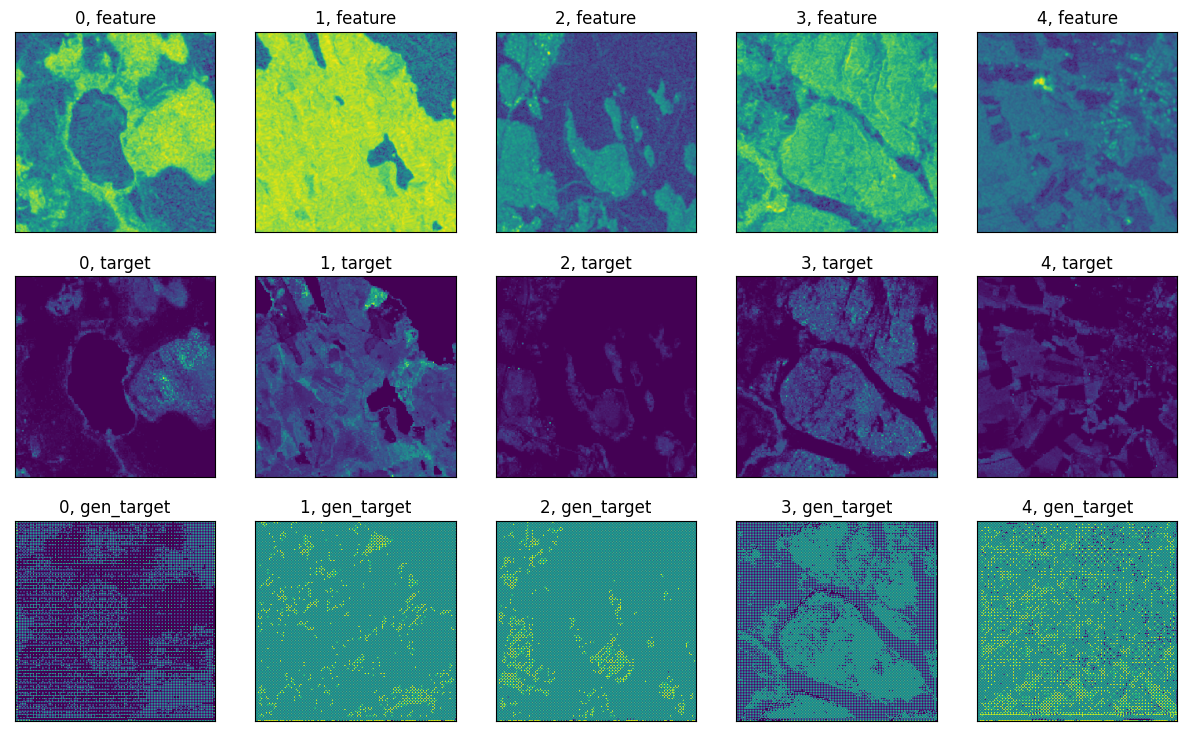

In [70]:
num_steps = 1 #len(train_dataloader)
batch_size = 5
channel = 5

fig, axes = plt.subplots(nrows=3*num_steps, ncols=batch_size, figsize=(3*batch_size,9*num_steps))
axes = axes.flatten()

j = 0
# for j, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
for i, (a, b, b_fake) in enumerate(zip(visuals['real_A'], visuals['real_B'], visuals['fake_B'])):
    data = {
        'feature': a[channel,:,:],
        'target': b[0,:,:],
        'gen_target': b_fake[0,:,:],
    }

    for k, (title, img) in enumerate(data.items()):
        idx = i+j*(3*batch_size) +k*batch_size
        axes[idx].imshow(img)
        axes[idx].set_title(f'{i}, {title}')
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])


## Training